# Fingerphotos recognition

Fingerprint recognition is probably the most mature biometric technique, which finds lots of real - life applications since long ago.
This notebook is for Authentication / Verification with fingerphotos. 

## Data
IIITD SmartPhone Fingerphoto Database v1 ([ISPFDv1](http://iab-rubric.org/resources/spfd.html)) consists of fingerphotos and live scan images captured using Lumidgm Sensor. It has data for 64 subjects, collected for both right index and right middle finger, hence making a total of 128 classes. This database covers illumination and background variation challenges.

In [1]:

import cv2
import numpy as np
import math 
import copy
import operator
from utils2 import *
#from skimage.measure import label  
#from skimage.morphology import skeletonize, thin
#from skimage import  morphology, filters
#from skimage.util import invert
from matplotlib import pyplot as plt

from utils import *
from constants import *
from preprocessing import *
from plots import *
import glob

from sklearn.metrics import accuracy_score, precision_score, f1_score

# pyeer library: pip install pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

In [2]:
#load filename
image_files_gallery = read_images_gallery()
image_files_probe = read_images_probe()
print('gallery:',len(image_files_gallery))
print('probe:',len(image_files_probe))

gallery: 32
probe: 32


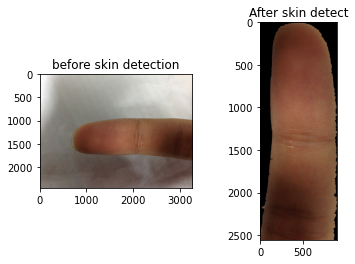

In [3]:
for i in range(0,len(image_files_gallery)):
    
    if(get_image_label(image_files_gallery[i])=='2_i_1_w_1.jpg'):
        img_fpr = cv2.imread(image_files_gallery[i])
        img= skinDetection(img_fpr)
    
        plt.subplot(1, 2, 1)
        plt.title('before skin detection')
        plt.imshow(cv2.cvtColor(img_fpr, cv2.COLOR_BGR2RGB), cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title('After skin detect')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
        plt.show()
        break

In [4]:
train_set = prepare_dataset_gallery(image_files_gallery) 


21
Processing image 2_i_1_w_1.jpg ...  
Processing image 2_i_1_w_2.jpg ...  
Processing image 2_i_1_w_3.jpg ...  
Processing image 2_i_1_w_4.jpg ...  
Processing image 2_i_1_w_5.jpg ...  
Processing image 2_i_1_w_6.jpg ...  
Processing image 2_i_1_w_7.jpg ...  
Processing image 2_i_1_w_8.jpg ...  
Processing image 2_i_2_w_1.jpg ...  
Processing image 2_i_2_w_2.jpg ...  
Processing image 2_i_2_w_3.jpg ...  
Processing image 2_i_2_w_4.jpg ...  
Processing image 2_i_2_w_5.jpg ...  
Processing image 2_i_2_w_6.jpg ...  
Processing image 2_i_2_w_7.jpg ...  
Processing image 2_i_2_w_8.jpg ...  
Processing image 3_i_1_w_1.jpg ...  
Processing image 3_i_1_w_2.jpg ...  
Processing image 3_i_1_w_3.jpg ...  
Processing image 3_i_1_w_4.jpg ...  
Processing image 3_i_1_w_5.jpg ...  
Processing image 3_i_1_w_6.jpg ...  
Processing image 3_i_1_w_7.jpg ...  
Processing image 3_i_1_w_8.jpg ...  
Processing image 3_i_2_w_1.jpg ...  
Processing image 3_i_2_w_2.jpg ...  
Processing image 3_i_2_w_3.jpg ... 

In [5]:
test_set = prepare_dataset_probe(image_files_probe) 

21
Processing image 2_o_1_n_1.jpg ...  
Processing image 2_o_1_n_2.jpg ...  
Processing image 2_o_1_n_3.jpg ...  
Processing image 2_o_1_n_4.jpg ...  
Processing image 2_o_1_n_5.jpg ...  
Processing image 2_o_1_n_6.jpg ...  
Processing image 2_o_1_n_7.jpg ...  
Processing image 2_o_1_n_8.jpg ...  
Processing image 2_o_2_n_1.jpg ...  
Processing image 2_o_2_n_2.jpg ...  
Processing image 2_o_2_n_3.jpg ...  
Processing image 2_o_2_n_4.jpg ...  
Processing image 2_o_2_n_5.jpg ...  
Processing image 2_o_2_n_6.jpg ...  
Processing image 2_o_2_n_7.jpg ...  
Processing image 2_o_2_n_8.jpg ...  
Processing image 3_o_1_n_1.jpg ...  
Processing image 3_o_1_n_2.jpg ...  
Processing image 3_o_1_n_3.jpg ...  
Processing image 3_o_1_n_4.jpg ...  
Processing image 3_o_1_n_5.jpg ...  
Processing image 3_o_1_n_6.jpg ...  
Processing image 3_o_1_n_7.jpg ...  
Processing image 3_o_1_n_8.jpg ...  
Processing image 3_o_2_n_1.jpg ...  
Processing image 3_o_2_n_2.jpg ...  
Processing image 3_o_2_n_3.jpg ... 

Checking the size of the training and test set. After the split of the dataset, there are 6 images per person (class) for train and 2 images for test. 
- train_set and test_set represent lists of tuples, with the form: (img_label, img)

In [6]:
print('Size of the training set:', len(train_set))
print('Size of the test set:', len(test_set))

Size of the training set: 32
Size of the test set: 32


Next, we plot one image before and after converting it to grayscale and appling enhancement.

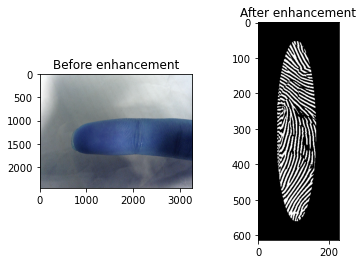

In [7]:
plt.subplot(1, 2, 1)
plt.title('Before enhancement')
img_fpr = cv2.imread(image_files_gallery[0])
plt.imshow(img_fpr, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('After enhancement')
plt.imshow(train_set['2_i_1_w_1.jpg'][0], cmap='gray')
plt.show()

We define few methods used for the authetication scenarios.

ORB (Oriented FAST and Rotated BRIEF) descriptor is used to find matching keypoints. As a matching function we use number of matching features whose distance is below a given threshold.

In [8]:
# Initiate ORB detector for matching keypoints
orb = cv2.ORB_create(MAX_FEATURES)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [9]:

    
    

def minutiaeToKeyPoints_old(FeaturesTerminations, FeaturesBifurcations):
    terminaison_id=1
    bifurcation_id=2
    result = []
    size=1
    response = 1
    octave = 1
    kps_term = [ cv2.KeyPoint(x=p.locX,y= p.locY, _size=size,_angle=p.Orientation[0],_response=response,
                                        _octave=octave,_class_id=terminaison_id) for p in FeaturesTerminations ] 
    
    kps_bifurc = [ cv2.KeyPoint(x=p.locX,y= p.locY, _size=size,_angle=p.Orientation[0],_response=response,
                                        _octave=octave,_class_id=terminaison_id) for p in FeaturesBifurcations ] 
    
    result=[*kps_term,*kps_bifurc]
    return result





def get_feature_keypoint_and_descriptor_old2(image,orb,padding,border=1):
    DispImg, FeaturesTerminations, FeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features2(image, showResult=False)
    keypoints=minutiaeToKeyPoints_old( FeaturesTerminations, FeaturesBifurcations)
    kp, des = orb.compute(image, keypoints)
    #print('kp',kp)
    #print('des',des)
    return (kp, des)

def get_feature_keypoint_and_descriptor_old(image,orb,padding,border=1):
    print(padding)
    DispImg, kp, des = detectMinutiae(image, border,orb,padding)
    #print('kp',kp)
    #print('des',des)
    plt.subplot(1, 1, 1)
    plt.title('minutiae detect')
    plt.imshow(DispImg, cmap='gray')
    plt.show()
    return (kp, des)



def get_feature_keypoint_and_descriptor(image,orb,padding,border=1):
    kp, des = orb.detectAndCompute(image, None)
    #print('kp',kp)
    #print('des',des)
    return (kp, des)

In [10]:
# Returns feature descripors for all images from the dataset
def get_feature_descriptors(dataset):
    feature_descriptors = {}
    for image_id, image_padding in dataset.items():
        image, padding=image_padding
        kp, des = get_feature_keypoint_and_descriptor(image, orb,padding)
        
        feature_descriptors[image_id] = des
    return feature_descriptors

In [11]:
# Returns best_matches between training features descriptors and query image
def get_best_matches(query_image,padding_query, trained_features, distance_threshold): 
    best_matches_dict = {}
    kp1, query_des = get_feature_keypoint_and_descriptor(query_image, orb,padding_query)
    for train_image_id, trained_feature_des in trained_features.items():
        if query_des is not None and trained_feature_des is not None:
            matches = bf.match(query_des, trained_feature_des)
            matches.sort(key=lambda x: x.distance, reverse=False) # sort matches based on feature distance
            
            best_matches = [m.distance for m in matches if m.distance < distance_threshold]
            best_matches_dict[train_image_id] = len(best_matches) # matching function = length of best matches to given threshold
    
    best_matches_dict = sorted(best_matches_dict.items(), key = operator.itemgetter(1), reverse=True) # sort by value - feature distance
    return best_matches_dict



In [12]:
from collections import defaultdict

def classify_fpr(best_matches_dict, rank):
    '''
    Counts how many fprs from the same class are there in the first ranked 
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param rank: To take the first ranked closest features
    :return first_rank_sorted: dictionary, where key denotes the fpr class and 
            the value is how many times it appears in the first ranked fprs
    '''
    first_rank_fprs = defaultdict(int)
    for fpr_name, distance in best_matches_dict[0:rank]:
        fpr_class = get_image_class(fpr_name)
        first_rank_fprs[fpr_class] += 1
            
    first_rank_sorted = sorted(first_rank_fprs.items(), key = operator.itemgetter(1), reverse=True) 
    return first_rank_sorted 

In [13]:
def draw_keypoints_matches(fpr1,padding_fpr1, fpr2,padding_fpr2):
    kp1, des1 = get_feature_keypoint_and_descriptor(fpr1, orb,padding_fpr1)
    kp2, des2 = get_feature_keypoint_and_descriptor(fpr2, orb,padding_fpr2)

    matches = bf.match(des1, des2)
    matches.sort(key=lambda x: x.distance, reverse=False)
    imMatches = cv2.drawMatches(fpr1, kp1, fpr2, kp2,matches[:10], None)

    plt.imshow(imMatches)
    plt.show()

In [14]:
#print(train_set['6_i_1_w_5.jpg'])

## Authentication scenario

 we analyse the authentication scenario, which corresponds to 1:1 problem or binary classification. The question that is asked is: “Can you prove who you are?”. A system will challenge someone to prove their identity and the person has to respond in order to allow them access to a system or service. For example, a person touches their finger on a sensor embedded in a smartphone, used by the authentication solution as part of a challenge/response system. "Is it my finger? Yes, then my smartphone is unlocked, or No it isn’t my finger and the smartphone remains locked." [2]

For the authentication scenairo, the data structure for training is slightly different, whereas the test set remains the same. For the training set, the already computed features are divided in separate dictionaries (that act as databases) where the key denotes the class (person), and then every image features for the correspoding class are set in the dictionary as a value.

In [15]:
train_feature_descriptors = get_feature_descriptors(train_set)
authentication_databases = prepare_dataset_authentication(train_feature_descriptors)

In [16]:
print('Classes in the training set = {}'.format(authentication_databases.keys()))

Classes in the training set = dict_keys(['21', '22', '31', '32'])


In [17]:
def count_same_fprs(feature_distances, len_best_matches):
    '''
    Counts how many fprs are close to the query fpr
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param len_best_matches: Predefined value for the length of best features
    :return count_same: number of same fprs paris within the given len_best_matches
    '''
    count_same = 0
    for features in feature_distances:
        if int(features[1]) > len_best_matches: # Compare the len of best features for the given feature with the predefined len
            count_same += 1
            
    return count_same

In [18]:
def perform_authentication_scenario(dist_threshold, len_best_matches):
    true_y = []
    pred_y = []
    total_distances = []
    print("----- START, Threshold = {} -----".format(dist_threshold))
    for authentication_db_key in authentication_databases.keys():
        authentication_db = authentication_databases[authentication_db_key]
        for test_image_id, test_image_test_padding in test_set.items(): 
            test_image, test_padding= test_image_test_padding
            best_matches_dict = get_best_matches(test_image,test_padding, authentication_db, dist_threshold)
            total_distances.append(best_matches_dict[0])
            
            count_same = count_same_fprs(best_matches_dict, len_best_matches)
            ratio = count_same/len(authentication_db.keys())
            test_image_class = get_image_class(test_image_id)
            true_class = 1 if test_image_class == authentication_db_key else 0
            true_y.append(true_class)
            
            if ratio >= 0.5: 
                pred_y.append(1)
            else:
                pred_y.append(0) 
    
    identical = true_y
    print("Accuracy is %f "%(round(accuracy_score(true_y, pred_y),4)))
    print('The precision score is {}'.format(precision_score(true_y, pred_y)))
    print('F1 score is {}'.format(round(f1_score(true_y, pred_y), 4)))

    return total_distances, identical

Before iterating through different thershold values and length of best matches, we show an example for authenticating one query fingerprint against all fprs databases.

In [19]:
# Example 

#list_test= list(test_set)
#print(list_test)
#test_image_id = list(test_set)[0]
#authentication_db = authentication_databases['61']
#best_matches_dict = get_best_matches(test_set[test_image_id][0],test_set[test_image_id][1], authentication_db , 50) 
#count_same = count_same_fprs(best_matches_dict, 10)
#ratio = count_same/len(authentication_db.keys())
#print('--- For query image: {} ---'.format(test_image_id))
#print('Probability of correct fpr for class 61 = {}'.format(round(ratio,4)))
#draw_keypoints_matches(test_set[test_image_id][0],test_set[test_image_id][1], train_set['6_i_1_w_1.jpg'][0], train_set['6_i_1_w_1.jpg'][1])

We can notice that there are ~ 100% chances that the person will be correctly authenticated.

In [20]:
len_best_matches = 15
for dist_threshold in range(30, 70, 10): 
    perform_authentication_scenario(dist_threshold, len_best_matches)

----- START, Threshold = 30 -----
Accuracy is 0.750000 
The precision score is 0.0
F1 score is 0.0
----- START, Threshold = 40 -----


/home/fokou/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy is 0.664100 
The precision score is 0.2608695652173913
F1 score is 0.2182
----- START, Threshold = 50 -----
Accuracy is 0.250000 
The precision score is 0.25
F1 score is 0.4
----- START, Threshold = 60 -----
Accuracy is 0.250000 
The precision score is 0.25
F1 score is 0.4


Highest accuracy score = 0.93 and precision score = 0.6, F1 score = 0.72, are obtained with distance threshold = 50.

In [21]:
distances, identical = perform_authentication_scenario(50, len_best_matches)
genuine_scores, impostor_scores = get_genuine_impostor_scores(distances, identical) 

----- START, Threshold = 50 -----
Accuracy is 0.250000 
The precision score is 0.25
F1 score is 0.4


[PyEER](https://github.com/manuelaguadomtz/pyeer) is a Python package intended for biometric systems performance evaluation. This package is used for computing the EER, as well as the FAR and FRR later.

EER represents a point where both FAR and FRR are equal.

In [22]:
stats = get_eer_stats(genuine_scores, impostor_scores)
generate_eer_report([stats], ['A'], 'pyeer_report.csv')

In [23]:
eer = round(stats.eer, 4)
print('Equal Error Rate is: {}'.format(eer))

Equal Error Rate is: 0.4115


The evaluation of 1:1 biometric authentication systems is usually done by estimating False Accept Rate (FAR) and False Reject Rate (FRR). Using these estimates, a ROC curve is generated. [1] Compared to the standard ROC curve, where we plot the True Positive Rate (TPR) against the False Positive Rate (FAR), in the domain of biometric sytems, instead of TPR, we plot FRR (or 1 - TPR).

### ROC curve  (FAR vs FRR)

Generating ROC curve: False accept rates vs. false reject rates


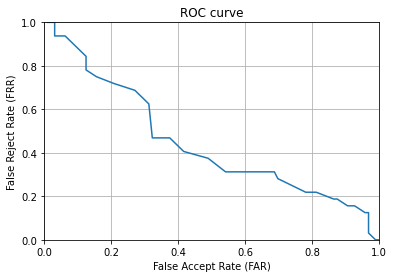

In [24]:
print('Generating ROC curve: False accept rates vs. false reject rates')
get_roc_curve(stats.fnmr, stats.fmr)

## References:

[1] R. M. Bolle, J. H. Connell, S. Pankanti, N. K. Ratha and A. W. Senior, "The relation between the ROC curve and the CMC," Fourth IEEE Workshop on Automatic Identification Advanced Technologies (AutoID'05), Buffalo, NY, USA, 2005, pp. 15-20.

[2] "Biometric Identification or Biometric Authentication?" Alan Goode, Retrieved from: https://www.veridiumid.com/blog